# Градиентный спуск своими руками

* Старайтесь сделать код как можно более оптимальным. В частности, не используйте циклы в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

In [ ]:
# import sys  
# !{sys.executable} -m pip install --user matplotlib

In [1]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

Ниже приведён базовый класс BaseLoss, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:

* Метод calc_loss, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения лосса
* Метод calc_grad, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения градиента (вектор)

In [3]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

### Реализуйте класс MSELoss

Он должен вычислять лосс и градиент

In [17]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        predictions = X @ w
        errors = predictions - y
        res = np.mean(errors**2)
        return res
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        n_objects = X.shape[0]
        predictions = X @ w
        errors = predictions - y
        res = (2/n_objects) * (X.T @ errors)
        return res

Теперь мы можем создать объект MSELoss и при помощи него вычислять значение нашей функции потерь и градиенты:

In [18]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


### Реализуйте функцию gradient_descent

Функция должна принимать на вход начальное значение весов линейной модели w_init, матрицу объектов-признаков X, вектор правильных ответов y, объект функции потерь loss, размер шага lr и количество итераций n_iterations.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из loss посредством вызова метода calc_grad) по формуле выше и возвращать траекторию спуска (список из новых значений весов на каждом шаге)

In [98]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    lst = []
    w = w_init
    for i in range(n_iterations):
        lst.append(w)
        w = w - lr * loss.calc_grad(X, y, w)
    
    return lst

In [99]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(42)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [100]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

276.01601930354724
1.0314024162116873


In [101]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(20, 10))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.colormaps['magma'])
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

### При помощи функций gradient_descent и plot_gd нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра lr). Используйте не менее четырёх разных значений для lr.

Сделайте и опишите свои выводы о том, как параметр lr влияет на поведение градиентного спуска

Подсказки:

* Функция gradient_descent возвращает историю весов, которую нужно подать в функцию plot_gd
* Хорошие значения для lr могут лежать в промежутке от 0.0001 до 0.1

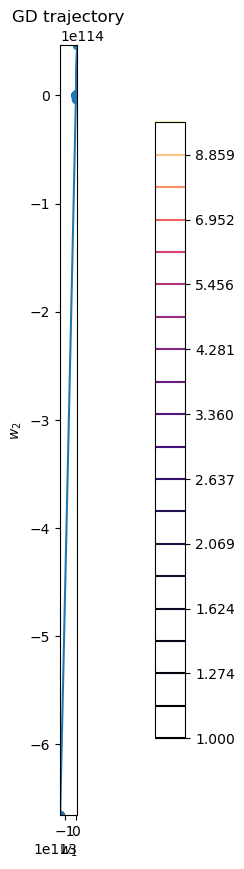

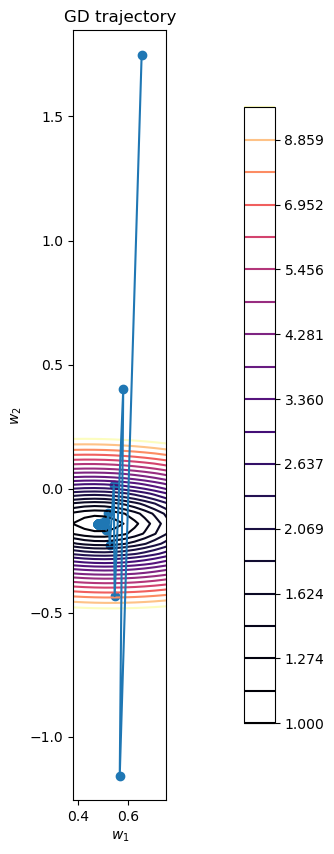

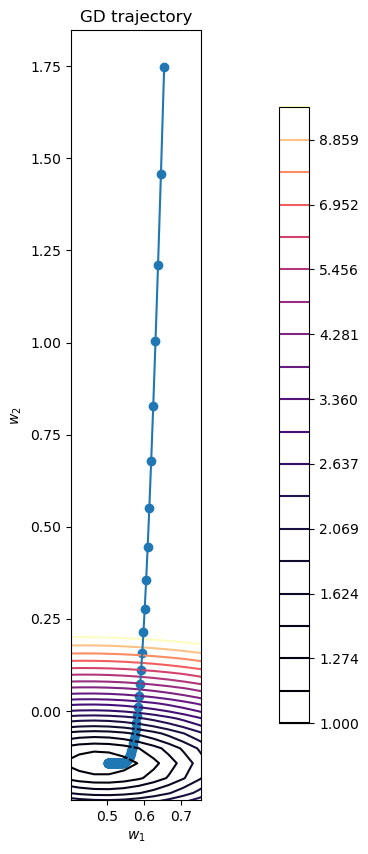

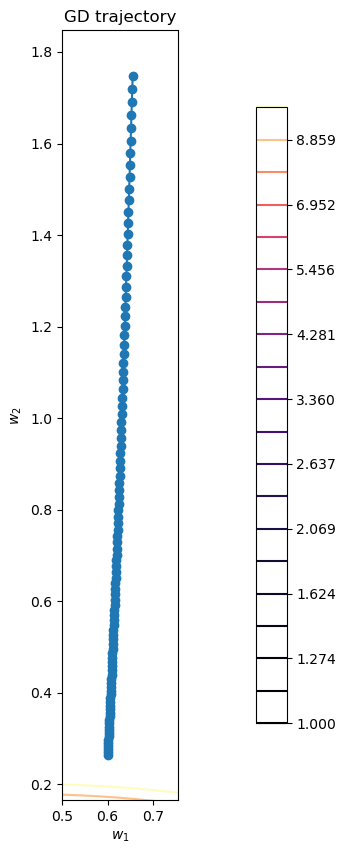

In [102]:
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.1, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.01, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.001, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.0001, n_iterations=100), X, y, MSELoss())

lr = 0.0001 слишком маленький поэтому за 100 итераций так и не дошло куда надо

lr = 0.001 подошел идеально как будто бы

lr = 0.01 довольно большеват, поэтому градиент прыгает через минимум туда сюда

lr = 0.1 настолько большой, что на графике ничего не понятно, производная улетает в небеса и никогда не придет в минимум 

Чем меньше lr, чем точнее, но тем больше итераций нужно, чтобы прийти в минимум. Нужно соблюдать баланс во вселенной


### *Реализуйте функцию stochastic_gradient_descent¶
Функция должна принимать все те же параметры, что и функция gradient_descent, но ещё параметр batch_size, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке X, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать np.random.choice с правильным параметром size, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив X:

batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)

batch = X[batch_indices]

In [108]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    lst = []
    
    w = w_init
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batchX = X[batch_indices]
        batchY = y[batch_indices]
        
        lst.append(w)
        w = w - lr * loss.calc_grad(batchX, batchY, w)
    
    return lst

### При помощи функций stochastic_gradient_descent и plot_gd нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра lr) и размера подвыборки (параметра batch_size). Используйте не менее четырёх разных значений для lr и batch_size.

Сделайте и опишите свои выводы о том, как параметры lr и batch_size влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что batch_size больше этого числа не будет иметь смысла.

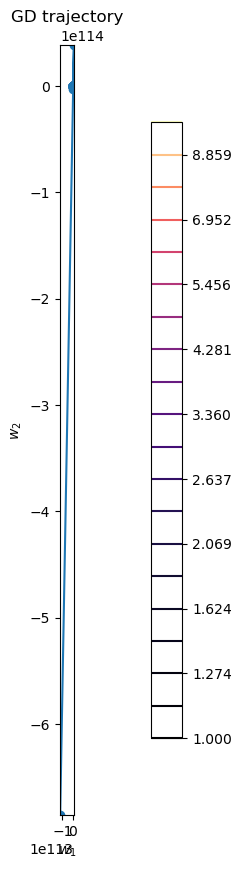

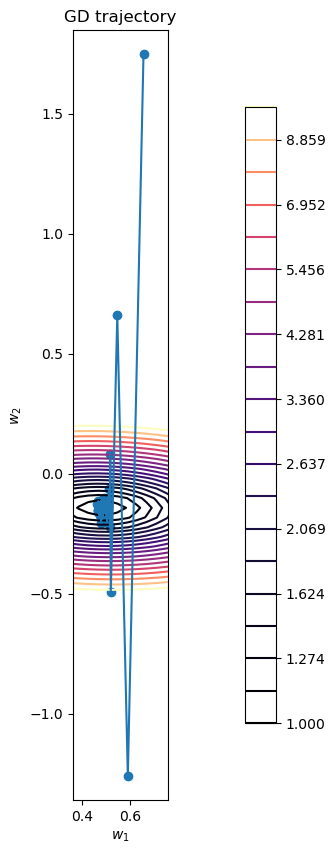

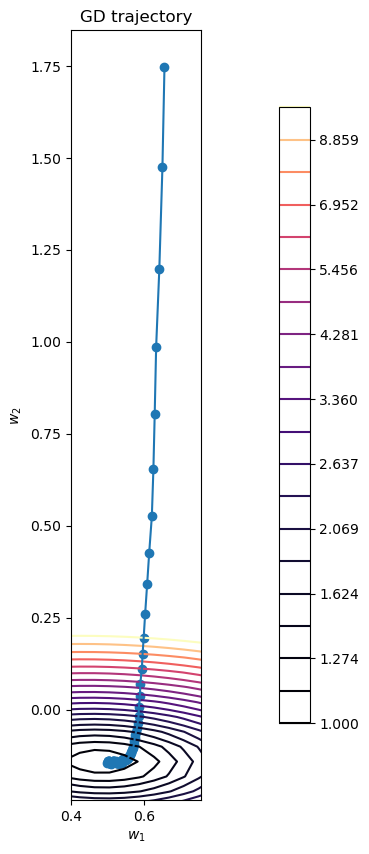

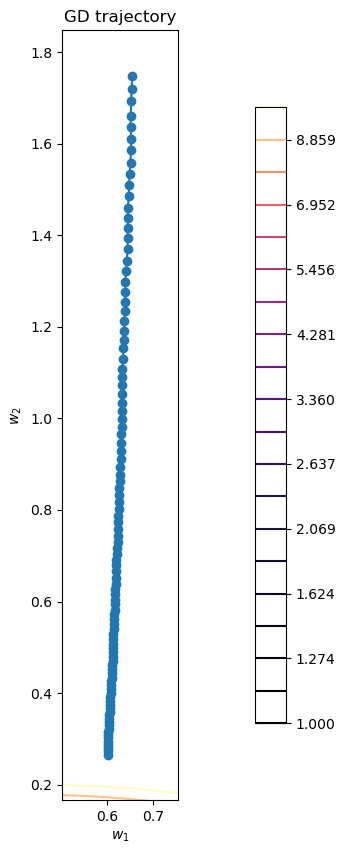

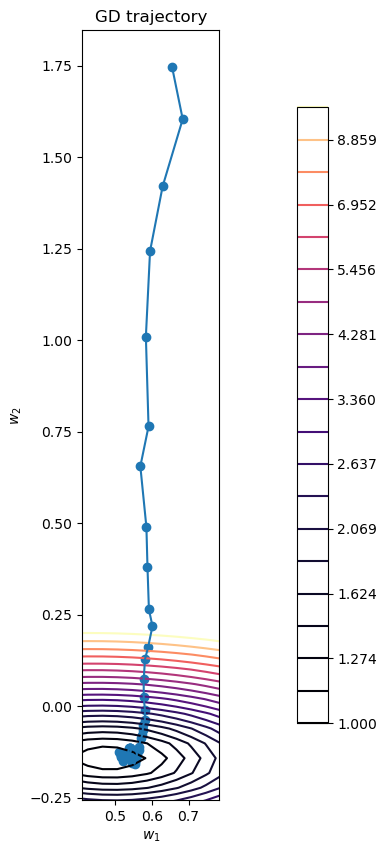

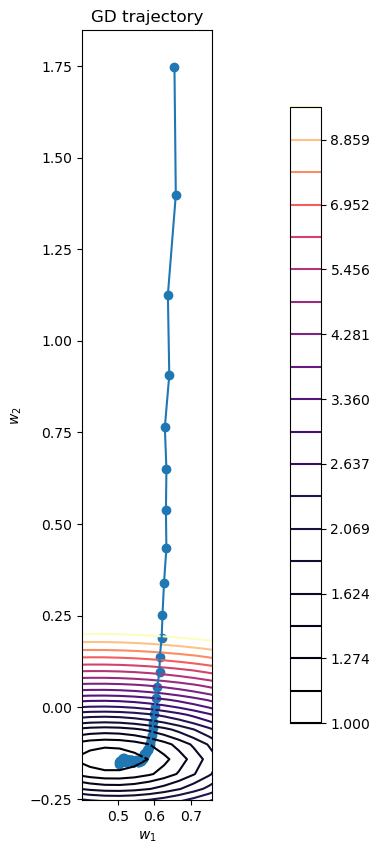

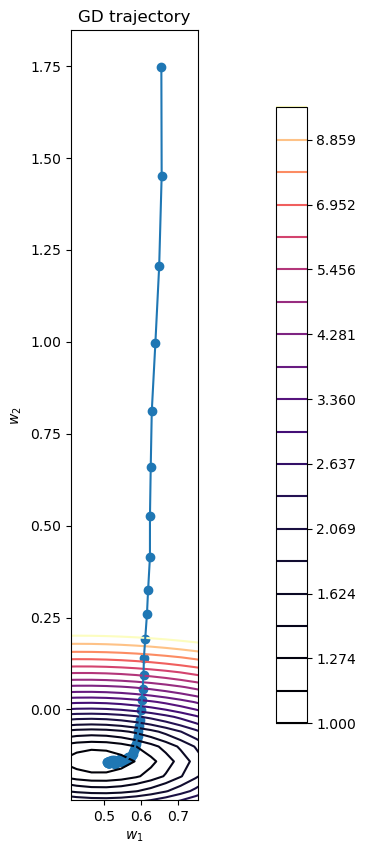

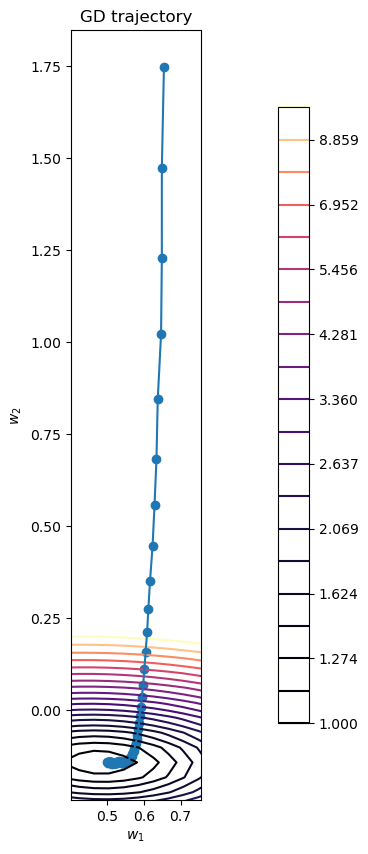

In [113]:
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.1,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.01,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.0001,batch_size=100, n_iterations=100), X, y, MSELoss())

plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=10, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=50, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=200, n_iterations=100), X, y, MSELoss())

От размера batch в целом, единственное, что я заметил, точки стали более рандомнее, но свой смысл сохранили, теперь отрабатывают не все точки из размера X и y, а только рандомный, количество которых мы задаем. Чем больше size batch'а, тем точнее, по крайней мере на моих графиках.

P.s. Я художник, я так вижу



# Линейная регрессия
Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки sklearn.

В методе fit мы будем подбирать веса w при помощи градиентного спуска нашим методом gradient_descent

В методе predict мы будем применять нашу регрессию к датасету,

### Допишите код в методах fit и predict класса LinearRegression

В методе fit вам нужно как-то инициализировать веса w, применить gradient_descent и сохранить последнюю w из траектории.

В методе predict вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в self.loss. Его нужно использовать в fit для gradient_descent

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        
        #ваш код
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        
        #ваш код
        
        pass

In [ ]:
linear_regression = LinearRegression(MSELoss())

In [ ]:
# !pip install numpy==1.26.4

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [ ]:
# !pip install scikit-learn

In [ ]:
# import sys  
# !{sys.executable} -m pip install --user scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_raw = X_raw.drop('index', axis=1) # Удаляем ненужный столбец
df = pd.DataFrame(data=X_raw)
df.info() #Посмотрим где какие признаки
df.isnull().sum() # Посчитаем пустые значения
nans = [1, 18, 19, 21, 22]
for i in nans:
    df[i] = df[i].fillna(df[i].mean()) # Заменяем в вещественных признаках наны на средние
df[5] = df[5].fillna('unknown') #заполнили пропуски и в категориальном признаке
features = [2,3,4,5,6,7,8,14,15,17]
categorical_features = pd.DataFrame(data=df[features]) #отделяем категориальные признаки и удаляем
df = df.drop(features, axis=1)
categorical_features = pd.get_dummies(categorical_features, prefix=features) # one-hot для категориальных
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(data=scaler.transform(df)) # нормализуем вещ признаки
df = df.merge(categorical_features, left_index=True, right_index=True) # вернули категориальные на место
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state=6)
x_train

### Обучите написанную вами линейную регрессию


### Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода mean_squared_error из sklearn.metrics

In [ ]:
from sklearn.metrics import mean_squared_error


### Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации 
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        pass
    
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
    
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        pass

### Обучите линейную регрессию и посмотрите что станет с лоссом

### *Попробуйте самостоятельно реализовать какой-то другой лосс и посмотреть что изменится:)